# Building a Multimodal Gradio Chatbot with Pydantic AI

In this notebook, we'll build a minimal Gradio chatbot that uses Pydantic AI to interact with Google Gemini. The chatbot will accept text, images, audio, and video inputs.

First, set up your credentials:

```bash
cp env.example .env
```

Then add your Gemini API key to `.env`:

```yaml
GEMINI_API_KEY=[your key]
```

Load the credentials:

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

# Verify API key is loaded
assert os.getenv("GEMINI_API_KEY"), "GEMINI_API_KEY not found. Please check your .env file."

## Defining our chatbot

In our case, the Agent is just a chatbot. We need an instance of a Pydantic AI Agent, and then a function we can use to chat with it, with an interface compatible with Gradio:

## Asynchronous programming

Before continuing, let's quickly review what async programming is, because we are going to leverage it:

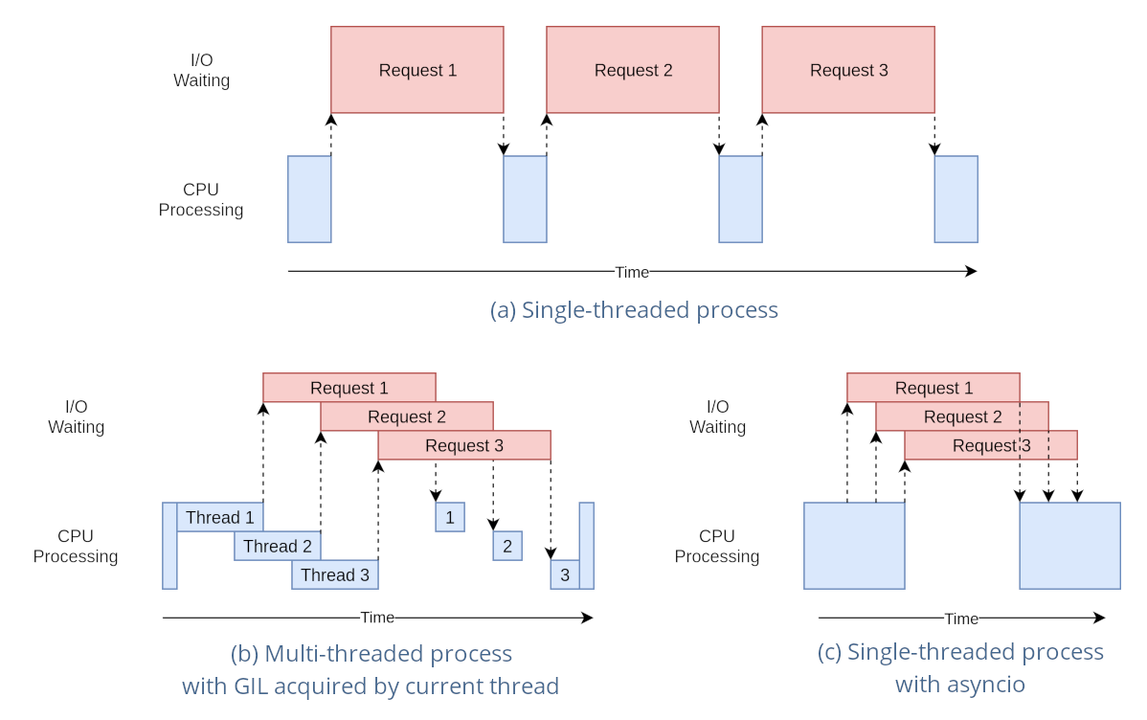

(from [https://realpython.com/python-concurrency/](https://realpython.com/python-concurrency/))

Why is it important? 

Your interface can handle multiple sessions concurrently, while working on the same CPU. Say that you have 3 users logged in and starting a conversation. The first one will generate request 1. While request 1 is in flight (and we are waiting for the answer from Gemini), gradio can pay attention to user 2, which will generate request 2. Now both request 1 and 2 are still being completed by Gemini, so gradio can pay attention to user 3 which will generate request 3. Then finally the answer to user 1 arrives. Gradio writes it to the UI, but now it needs to wait for the user to write something else. In the meantime, gradio can go back to see if response 2 or 3 arrived. Say now response 2 has arrived, gradio can write it to the UI, and now while it waits for user 2 to do something it can go back to receive answer 3. Thanks to async programming, gradio can deal with 3 users on a single CPU without multithreading or multiprocessing.

In order for gradio to work this way, we need to provide async functions to deal with out chatbot, and so this is what we're going to do.

## Building the Chat Function

The core of our chatbot is a function that processes user messages and returns AI responses:

In [3]:
from pydantic_ai import Agent
from pydantic_ai.messages import BinaryContent
from pydantic_ai.models.google import GoogleModel, GoogleModelSettings

import uuid
import filetype

# These are the MIME types supported by Gemini as of today
# (see https://cloud.google.com/vertex-ai/generative-ai/docs/models/gemini/2-5-flash)
SUPPORTED_MIME_TYPES = [
    # Image
    "image/png",
    "image/jpeg",
    "image/webp",
    # Text
    "application/pdf",
    "text/plain",
    # Video
    "video/x-flv",
    "video/quicktime",
    "video/mpeg",
    "video/mpegs",
    "video/mpg",
    "video/mp4",
    "video/webm",
    "video/wmv",
    "video/3gpp",
    # Audio
    "audio/x-aac",
    "audio/flac",
    "audio/mp3",
    "audio/m4a",
    "audio/mpeg",
    "audio/mpga",
    "audio/mp4",
    "audio/ogg",
    "audio/pcm",
    "audio/wav",
    "audio/x-wav",
    "audio/webm",
]


class ChatSession:
    
    def __init__(self, agent: Agent):

        # unique identifier for the session
        self.session_id = str(uuid.uuid4())

        # Create a Pydantic AI agent with Gemini
        self.agent = agent
        
    # This function will be called by Gradio when the user sends a message
    async def chat(
        self, message, history, past_messages
    ):
        """
        Args:
            message: dict with 'text' and optional 'files' keys
            history: Gradio's chat history (for display only, we ignore it)
            past_messages: Pydantic AI's message history (the one we actually use)
        """
        prompt_parts = []

        # See if the input coming from gradio (i.e., from the user)
        # has a text part
        if message.get("text"):

            prompt_parts.append(message["text"])

        # See if the input coming from gradio (i.e., from the user)
        # has any files attached
        if message.get("files"):

            for file_path in message["files"]:

                # Check that we have a valid media type
                kind = filetype.guess(file_path)

                if (
                    kind is None  # not recognized
                    or not kind.mime  # no MIME type
                    or kind.mime not in SUPPORTED_MIME_TYPES
                ):

                    # Not a recognized media type, skip it
                    raise IOError(
                        f"Unsupported file type: {file_path} ({kind.mime if kind else 'unknown'})"
                    )

                else:

                    with open(file_path, "rb") as f:
                        file_bytes = f.read()

                    # Add the file content as BinaryContent to the prompt parts
                    # Pydantic AI will handle uploading it to Gemini
                    # We also specify the media type (MIME type)
                    # Note: for large files, you will need to use the File API
                    # Here we do direct upload for simplicity
                    prompt_parts.append(
                        BinaryContent(data=file_bytes, media_type=kind.mime)
                    )

        if not prompt_parts:
            raise ValueError("Please provide a message or at least one file.")

        # Here we use await, since agent.run is an async method
        # This signals to python that this is a potentially long-running operation
        # (e.g., waiting for a response from the AI model) and
        # it should allow other tasks to run in the meantime, while we wait
        result = await self.agent.run(prompt_parts, message_history=past_messages)

        # After we finished waiting, we return both the response AND the updated history
        return result.output, result.all_messages()

## Primer on Gradio

Gradio is a Python library that lets you create web interfaces for your Python functions with just a few lines of code. No HTML, CSS, or JavaScript required!

### Core Concepts

#### 1. Components (Inputs & Outputs)

Components are the building blocks of your interface. Common ones include:

- `gr.Textbox()` - text input/output
- `gr.File()` - file uploads
- `gr.Image()` - display images
- `gr.Audio()` - play/record audio
- `gr.Video()` - video player
- `gr.Dataframe()` - tables of data
- `gr.Button()` - clickable buttons
- `gr.Chatbot()` - chat message display

#### 2. Different Ways to Build Interfaces

**Option A: `gr.Interface()` - Simple and quick**
```python
demo = gr.Interface(fn=my_function, inputs=..., outputs=...)
```

**Option B: `gr.Blocks()` - Full control over layout**
```python
with gr.Blocks() as demo:
    # Arrange components however you want
```

**Option C: `gr.ChatInterface()` - Pre-built chat UI**
```python
demo = gr.ChatInterface(fn=chat_function, ...)
```

#### 3. Layout Elements (Blocks only)

- `gr.Row()` - arrange components horizontally
- `gr.Column()` - arrange components vertically (default)
- `gr.Tab()` - create tabbed sections

#### 4. Connecting Components to Functions

Use `.click()` for buttons to specify what happens when clicked:

```python
button.click(
    fn=my_function,           # Function to run
    inputs=[input1, input2],  # What to pass to the function
    outputs=[output1]         # Where to display results
)
```

#### 5. State Management

`gr.State()` lets you persist data across interactions (like keeping chat history):

```python
state = gr.State([])  # Initialize empty list
# Pass as additional_inputs and additional_outputs
```

#### 6. Launching Your App

```python
if __name__ == "__main__":
    demo.launch(share=False)  # share=True creates public link
```

### Key Takeaways

1. **Components** = UI elements (textboxes, buttons, images, etc.)
2. **Functions** = Your Python code that does the work
3. **Events** = `.click()` connects components to functions
4. **Blocks** = Build custom layouts with rows/columns
5. **ChatInterface** = Ready-made chat UI (less code!)

That's it! You can now understand and modify Gradio apps.

## Creating the Gradio Interface

Now we'll build the Gradio UI using `gr.ChatInterface` with multimodal support. This gives us a professional-looking chatbot in just a few lines of code.

In [ ]:
import gradio as gr
from rate_limiting import rate_limit

class GradioWrapper:
    """
    Wrapper around ChatSession to handle errors in Gradio
    """

    def __init__(self, chat_session: ChatSession):
        self.chat_session = chat_session
    
    @rate_limit(calls=120, period=60)
    async def chat_gradio(self, message, history, past_messages):
        """
        Wrapper around chat() to catch and display errors in Gradio apps.
        """

        try:
            return await self.chat_session.chat(message, history, past_messages)
        except Exception as e:

            raise gr.Error(f"Error: {str(e)}")


agent = Agent(
    model=GoogleModel("gemini-2.5-flash-lite"),
    # You typically want to set a much more specific system prompt, depending on
    # your application. Here we keep it generic.
    system_prompt="You are a helpful AI assistant. Be concise and friendly.",
    # Good practice: limit the max response tokens to avoid excessive usage
    # You might also want to consider limiting the thinking budget
    # (a token is ~0.75 words of English, so 1024 tokens is about 750 words)
    model_settings=GoogleModelSettings(max_response_tokens=1024),
    # Automatically retries in case of transitory errors
    retries=3
)

gradio_chat_session = GradioWrapper(ChatSession(agent))

# State to hold Pydantic AI's message history
past_messages_state = gr.State([])

# Create the chatbot interface
demo = gr.ChatInterface(
    # fn is the function that drives the chatbot
    # For us, it is the chat method
    # NOTE: gradio automatically recognizes async functions and handles them appropriately
    fn=gradio_chat_session.chat_gradio,
    type="messages",
    # Enable multimodal inputs
    multimodal=True,
    title="Multimodal AI Chatbot",
    description="Chat with Gemini! Upload images, audio, or video files along with your questions.",
    # This is the field where the user types messages or uploads files
    textbox=gr.MultimodalTextbox(
        # Allow to upload multiple files of specified types
        file_count="multiple",
        # Allow images, audio, and video files
        file_types=["image", "audio", "video", "text", ".pdf"],
        # Placeholder text
        placeholder="Type a message or upload files (images, audio, video, text, pdf)...",
    ),
    # This is where the chat history is displayed
    chatbot=gr.Chatbot(
        height=300,
        show_copy_button=True,
        placeholder="👋 Hello! I'm your AI assistant. Upload media files or just chat with me!",
        type="messages",
    ),
    # Need to manage state for Pydantic AI's message history
    additional_inputs=[past_messages_state],  # Add the state as input
    additional_outputs=[past_messages_state],  # Add the state as output
)

# Launch the app
if __name__ == "__main__":
    demo.launch(share=True)  # Set share=True to create a public link

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


## Streaming the response

Pydantic AI has built-in support for streaming responses. Sometimes, when the output is long, we want to see it as it comes, instead of waiting for it all at once.

> NOTE: this does NOT work in our test environment, as streaming is not supported by the custom server we use to interface with Gemini. It would however work if you use directly Gemini through the Google endpoints or Vertex AI

Anyway, this is how you would do it.

This part:

```python
        result = await self.agent.run(prompt_parts, message_history=past_messages)

        # After we finished waiting, we return both the response AND the updated history
        return result.output, result.all_messages()
```

becomes this:

```python
        async with self.agent.run_stream(prompt_parts, message_history=past_messages) as result:
            # Stream the text as it comes in
            async for text_chunk in result.stream_text():
                yield text_chunk, past_messages
            
            # After streaming is complete, get the updated message history
            updated_messages = result.all_messages()
            yield text_chunk, updated_messages
```

We also need to change the wrapper accordingly:

```python
from rate_limiting import rate_limit_streaming

class GradioWrapper:
    ...
    
    # Use version of rate limiting for generators
    @rate_limit_streaming(calls=120, period=60)
    async def chat_gradio(self, message, history, past_messages):
        """
        Wrapper around chat() to catch and display errors in Gradio apps.
        """

        try:

            # Forward to the generator
            async for text_chunk, past_messages in self.chat_session.chat(
                message, history, past_messages
            ):
                yield text_chunk, past_messages
        
        except Exception as e:

            raise gr.Error(f"Error: {str(e)}")
```

## More customized app with structured output

For specific use cases we might want a different interface than a chatbot. This is easy to do with Gradio and pydantic AI.

Let's say we want to to sentiment analysis of whatever media is uploaded. We can define our pydantic AI agent with structured output, then use the same ChatSession class we created before:

In [14]:
from typing_extensions import Literal
import gradio as gr
import pandas as pd

from pydantic import BaseModel, Field
from pydantic_ai import Agent
from pydantic_ai.models.google import GoogleModel, GoogleModelSettings


class AnalysisResult(BaseModel):
    content_summary: str = Field(..., description="Summary of the content, divided by content type")

    sentiment: Literal["positive", "neutral", "negative"] = Field(
        ..., description="Sentiment of the content"
    )


# Create a Pydantic AI agent with Gemini and specify the output model
agent = Agent(
    model=GoogleModel("gemini-2.5-flash-lite"),
    # You typically want to set a much more specific system prompt, depending on
    # your application. Here we keep it generic.
    system_prompt="You are a helpful AI assistant. Be concise and friendly.",
    # Good practice: limit the max response tokens to avoid excessive usage
    # You might also want to consider limiting the thinking budget
    # (a token is ~0.75 words of English, so 1024 tokens is about 750 words)
    model_settings=GoogleModelSettings(max_response_tokens=1024),
    # Specify the output model
    output_type=AnalysisResult,
)

gradio_chat_session = GradioWrapper(ChatSession(agent))

Now let's create a simple gradio interface that allows the user to write text and upload a file, and then click process to run the analysis. The results will be displayed as a table.

Gradio will send us the text defined and the file uploaded, if any. This is a little different than what the chat interface was sending us, and that our ChatSession class expected:

```
async def chat_gradio(self, message, history, past_messages):
    ...
```
so we need to write a little connector that takes the text and file coming from our Gradio interface, and reformat them in the format that our ChatSession expects:

In [ ]:
from rate_limiting import rate_limit
import pandas as pd


class GradioWrapperCustomApp:
    """
    Wrapper around ChatSession to format inputs and handle errors in Gradio
    """

    def __init__(self, chat_session: ChatSession):
        self.chat_session = chat_session

    # Apply rate limiting to our chat function
    # (say 120 calls per minute, i.e., 2 calls per second on average)
    @rate_limit(calls=120, period=60)
    async def chat_gradio(self, text, file):
        """
        Wrapper around chat() to catch and display errors in Gradio apps.
        """

        message = {"text": text}
        if file:
            message["files"] = [file]

        try:
            # This is a one-shot interaction, so we pass empty history
            # and past messages, and we ignore the chat history returned
            result, _ = await self.chat_session.chat(message, [], [])
        except Exception as e:

            raise gr.Error(f"Error: {str(e)}")

        # Convert Pydantic model to DataFrame
        df = pd.DataFrame([result.model_dump()])

        # Return file path for display components
        return df, file, file, file


wrapper = GradioWrapperCustomApp(ChatSession(agent))

with gr.Blocks() as demo:
    with gr.Row():
        text_input = gr.Textbox(label="Text Input")
        file_input = gr.File(
            label="Upload File", file_types=["audio", "image", "video"]
        )

    with gr.Row():
        submit_btn = gr.Button("Analyze", variant="primary")
        clear_btn = gr.Button("Clear")

    output_table = gr.Dataframe(label="Results", wrap=True)

    with gr.Row():
        image_output = gr.Image(label="Uploaded Image", visible=True)
        video_output = gr.Video(label="Uploaded Video", visible=True)
        audio_output = gr.Audio(label="Uploaded Audio", visible=True)

    submit_btn.click(
        fn=wrapper.chat_gradio,
        # This will become the input to chat_gradio
        inputs=[text_input, file_input],
        # The output of chat_gradio will be forwarded to these components
        # so chat_gradio outputs a DataFrame and 3 file paths
        # The dataframe will go to the output_table, the 3 file paths to the 3 media components
        # Depending on the file type, only one of the 3 media components will actually display something
        # the others will ignore it
        outputs=[output_table, image_output, video_output, audio_output],
    )

    clear_btn.click(
        # Reset all components by creating a lambda that receives
        # nothing and returns one None for each component
        fn=lambda: (None, None, None, None, None, None),
        # Inputs to the lambda, which is nothing
        inputs=[],
        # Outputs of the lambda will be used to reset these components
        # in order:
        outputs=[
            text_input,
            file_input,
            output_table,
            image_output,
            video_output,
            audio_output,
        ],
    )

if __name__ == "__main__":
    demo.launch(share=True, inline=True)

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/Users/giacomov/develop/cd13331-multimodal/l5/demos/1-gradio-unified-api/.venv/lib/python3.12/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/giacomov/develop/cd13331-multimodal/l5/demos/1-gradio-unified-api/.venv/lib/python3.12/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/giacomov/develop/cd13331-multimodal/l5/demos/1-gradio-unified-api/.venv/lib/python3.12/site-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/Users/giacomov/develop/cd13331-multimodal/l5/demos/1-gradio-unified-api/.venv/lib/python3.12/site-packages/starlette/applications.py", l